### Demonstrativos financeiros

Uma companhia de capital aberto deve apurar as seguintes demonstrações em atendimento às exigências da Comissão de Valores Mobiliários (CVM), B3 e seus acionistas:

*Demonstrações Financeiras Padronizadas* (DFP) – Este documento é composto por todos os demonstrativos financeiros referentes ao exercício social encerrado, e deve ser encaminhado ao final de cada trimestre de cada ano à CVM e à B3. https://dados.cvm.gov.br/dataset/cia_aberta-doc-dfp 
Deve ser entregue pelo emissor nacional em até 3 (três) meses contados do encerramento do exercício social ou na mesma data de envio das demonstrações financeiras, o que ocorrer primeiro.

*Informações e Resultados Trimestrais* (ITR) – São elaborados e enviados por todas as companhias listadas em Bolsa de Valores para a CVM e B3 todo trimestre. A ITR tem por finalidade permitir que o investidor acompanhe o desempenho da empresa no trimestre. https://dados.cvm.gov.br/dataset/cia_aberta-doc-itr
Deve ser entregue pelo emissor no prazo de 45 (quarenta e cinco) dias contados da data de encerramento
de cada trimestre.

Relatórios contábeis elaborados periodicamente pelas empresas. 
- Balanço Patrimonial Ativo (BPA)
- Balanço Patrimonial Passivo (BPP)
- Demonstração de Fluxo de Caixa - Método Direto (DFC-MD)
- Demonstração de Fluxo de Caixa - Método Indireto (DFC-MI)
- Demonstração das Mutações do Patrimônio Líquido (DMPL)
- Demonstração de Resultado Abrangente (DRA)
- Demonstração de Resultado (DRE)
- Demonstração de Valor Adicionado (DVA)

In [37]:
ano_inicio  = 2019
ano_fim     = 2023
empresa     = 'itausa' 
relatorios  = ['DRE']

In [38]:
import os
import pandas as pd
import urllib.request
from zipfile import ZipFile

In [39]:
def download_data( start_year = ano_inicio, end_year = ano_fim , reports = relatorios , annual = True , rm=True) : 

    '''Baixa demosntrativos financeiros do site da CVM

    Args:
        start_year (int): ano inicial
        end_year (int): ano final 
        reports (list): lista de nomes dos relatorios que deseja (consolidado):
            'BPA_con', 'BPP_con', 'DRE_con', 'DFC_MD_con', 'DFC_MI_con', 'DMPL_con'
        annual (bool): se True, baixa dre anual, senão semestral
        rm (bool): se True, renmove arquivos baixados e unzipados

    Returns:
        caminho e/dos Arquivos .csv com os dados reunidos por ano.
'''

    relatorios = [x if x.endswith('_con') else x + '_con' for x in reports]

    if annual : dreP = 'dfp'
    else : dreP = 'itr'

    path_code = os.getcwd()
    path_data = path_code+'/data'
    path_unzip= path_data+'/'+dreP

    # Define a url dos dados da DFP
    url_cvm = f'https://dados.cvm.gov.br/dados/CIA_ABERTA/DOC/{dreP.upper()}/DADOS/'


    for ano in range(start_year, end_year + 1):
        url = url_cvm+f'{dreP}_cia_aberta_{ano}.zip'
        # Combina path_data com o nome do arquivo extraído da URL.
        arquivo_local = os.path.join(path_data, os.path.basename(url))
        #Baixa o arquivo da URL e o salva no caminho especificado por arquivo_local.
        urllib.request.urlretrieve(url, arquivo_local) 
        # Abre o arquivo ZIP baixado para leitura ('r').
        # extractall(): Extrai o conteúdo do arquivo ZIP para o diretório indicado
        ZipFile(path_data+'/'+f'{dreP}_cia_aberta_{ano}.zip', 'r').extractall(f'data/{dreP}')

    dados_dre = pd.DataFrame()

    # Concatena os dados em um DataFrame
    for planilhas in relatorios:
        demonstrativo = pd.DataFrame()
        for ano in range(start_year, end_year + 1):
            arquivo = f'{path_unzip}/{dreP}_cia_aberta_{planilhas}_{ano}.csv'
            le_arquivo = pd.read_csv(arquivo,sep = ';', decimal = ',', encoding = 'ISO-8859-1',dtype = {"ORDEM_EXERC": "category"})
            frames=[demonstrativo, le_arquivo]
            demonstrativo = pd.concat(frames)

        demonstrativo.to_csv(f'{path_unzip}/dfp_{planilhas}_{start_year}-{end_year}.csv', index = False) 

    #remove os arquivos baixados
    if rm: 
        for filename in os.listdir(path_data):
            file_path = os.path.join(path_data, filename)
            if os.path.isfile(file_path) and filename.endswith('.zip'):
                os.remove(file_path)
                print(f"Removidos: {file_path}", end=', ')
        # Remova quase todos os arquivos .csv
        for filename in os.listdir(path_unzip):
            file_path = os.path.join(path_unzip, filename)
            if os.path.isfile(file_path) and filename.endswith('.csv') and 'cia_aberta' in filename:
                os.remove(file_path)
                print(f"{file_path}", end=', ')
    
    return path_unzip

# ---

def show_table(data, conta):
  
    ''' Mostra uma tabela organizada 

    Args:
        data (DataFrame): DataFrame do demonstrativo
        conta (list): Lista dos códigos das contas que se deseja filtrar

    Returns:
        DataFrame
'''

    # filtra as contas e as colunas de interesse
    data = data[data.CD_CONTA.isin(conta)][['DT_REFER','CD_CONTA','DS_CONTA','VL_CONTA']].drop_duplicates()
    data['DT_REFER'] = pd.to_datetime(data['DT_REFER'])
    data['Ano'] = data['DT_REFER'].dt.year.astype(str)
    data.reset_index(inplace = True, drop = True)

    data_pivot = data.pivot(index = ['CD_CONTA','DS_CONTA'], columns = 'Ano', values = 'VL_CONTA')

    year_cols = list(map(str,list(range(ano_inicio,ano_fim+1))))
    pct_changes = round(data_pivot[year_cols].pct_change(axis=1).iloc[:,1:] * 100, ndigits = 2)
    pct_changes.columns = [f'{start}-{end} Δ%' for start, end in zip(year_cols[:-1], year_cols[1:])]

    colunas_intercaladas = [col for pair in zip(data_pivot.columns, pct_changes.columns) for col in pair]
    colunas_intercaladas.append(data_pivot.columns[-1])

    return pd.concat([data_pivot, pct_changes], axis=1)[colunas_intercaladas]
#   return data_pivot


In [41]:
path=download_data()

Removidos: /home/yair/GHub/Codigos-em-financas/data/dfp_cia_aberta_2021.zip, Removidos: /home/yair/GHub/Codigos-em-financas/data/dfp_cia_aberta_2020.zip, Removidos: /home/yair/GHub/Codigos-em-financas/data/dfp_cia_aberta_2022.zip, Removidos: /home/yair/GHub/Codigos-em-financas/data/dfp_cia_aberta_2023.zip, Removidos: /home/yair/GHub/Codigos-em-financas/data/dfp_cia_aberta_2019.zip, /home/yair/GHub/Codigos-em-financas/data/dfp/dfp_cia_aberta_2019.csv, /home/yair/GHub/Codigos-em-financas/data/dfp/dfp_cia_aberta_DRE_con_2023.csv, /home/yair/GHub/Codigos-em-financas/data/dfp/dfp_cia_aberta_DVA_ind_2021.csv, /home/yair/GHub/Codigos-em-financas/data/dfp/dfp_cia_aberta_BPP_con_2022.csv, /home/yair/GHub/Codigos-em-financas/data/dfp/dfp_cia_aberta_DFC_MI_ind_2019.csv, /home/yair/GHub/Codigos-em-financas/data/dfp/dfp_cia_aberta_DFC_MI_con_2023.csv, /home/yair/GHub/Codigos-em-financas/data/dfp/dfp_cia_aberta_DRE_con_2019.csv, /home/yair/GHub/Codigos-em-financas/data/dfp/dfp_cia_aberta_DRE_ind_202

DRE

In [58]:
## DRE
for filename in os.listdir(path):
    if filename.endswith('.csv') and 'DRE' in filename:
        dre = pd.read_csv(f'{path}/{filename}')
# dre

In [59]:
busca = empresa.strip().upper()
while True: 
    resultado = dre[dre['DENOM_CIA'].str.contains(busca)][['DENOM_CIA', 'CD_CVM']]
    if resultado.empty:
        print(f"Nenhum resultado encontrado para '{busca}'. Tente novamente com outra palavra-chave.")
        busca = input("Digite uma palavra-chave para buscar na coluna 'DENOM_CIA': ").strip().upper()
    else:
        print(resultado.drop_duplicates())
        break  # Sai do loop

                        DENOM_CIA  CD_CVM
21295  ITAU UNIBANCO HOLDING S.A.   19348


In [60]:
cod_cvm= int(input(f"Digite o código CVM dentre {list(resultado['CD_CVM'].drop_duplicates().values)}: "))
empresa = dre[dre['CD_CVM']==cod_cvm]['DENOM_CIA'].drop_duplicates().values[0]
empresa

'ITAU UNIBANCO HOLDING S.A.'

In [78]:
tabela = dre[(dre['CD_CVM']==cod_cvm) & (dre['ORDEM_EXERC']=='ÚLTIMO')]

In [85]:
from IPython.display import display, HTML
conta = tabela[['CD_CONTA', 'DS_CONTA' , 'VL_CONTA']]#.drop_duplicates()
display(HTML(conta.to_html(index=False)))


CD_CONTA,DS_CONTA,VL_CONTA
3.01,Receitas da Intermediação Financeira,1.930370e+08
3.01.01,Rec de Juros e Rend de Ativos Fin ao Custo Amort e ao Valor Justopor meio de Outros Res Abrangente,1.175230e+08
3.01.02,"Rec de Juros, Rend e Dividendos de Ativos Fin ao Valor Justo por meio do Resultado",2.276000e+07
3.01.03,Ajuste ao Valor Justo de Ativos e Passivos Financeiros,4.098000e+06
3.01.04,Resultado de Operações de Câmbio e Variação Cambial de Transações no Exterior,9.270000e+05
3.01.05,Receita de Prestação de Serviços,3.903200e+07
3.01.06,Res de Oper de Seguros e Prev Privada antes das Despesas com Sinistros ede Comercialização,4.553000e+06
3.01.07,Outras Receitas,4.144000e+06
3.02,Despesas da Intermediação Financeira,-7.595800e+07
3.02.01,Despesas de Juros e Rendimentos,-7.595800e+07


In [63]:
filtro = ['3.01', '3.02', '3.03', '3.04', '3.04.01' , '3.04.02' ,
          '3.04.06' ,'3.05', '3.06', '3.07', '3.08', '3.09', '3.10',
            '3.11','3.99.01','3.99.01.01','3.99.01.02'	]

In [65]:
display(HTML(show_table(tabela,filtro).reset_index().drop('CD_CONTA', axis = 1).to_html(index=False)))

DS_CONTA,2019,2019-2020 Δ%,2020,2020-2021 Δ%,2021,2021-2022 Δ%,2022,2022-2023 Δ%,2023
Receitas da Intermediação Financeira,193037000.0,-9.99,173757000.00,12.62,195679000.00,44.81,2.833720e+08,10.53,3.132210e+08
Despesas da Intermediação Financeira,-75958000.0,-3.16,-73558000.00,-5.78,-69305000.00,142.12,-1.678020e+08,12.45,-1.886950e+08
Resultado Bruto Intermediação Financeira,117079000.0,-14.42,100199000.00,26.12,126374000.00,-8.55,1.155700e+08,7.75,1.245260e+08
Outras Despesas/Receitas Operacionais,-85836000.0,10.64,-94969000.00,-11.40,-84143000.00,-7.26,-7.803700e+07,8.70,-8.482600e+07
Receitas de Prestação de Serviços,0.0,NaN,0.00,NaN,0.00,NaN,0.000000e+00,NaN,0.000000e+00
Despesas de Pessoal,-28415000.0,-11.46,-25158000.00,-100.00,0.00,NaN,0.000000e+00,NaN,0.000000e+00
Outras Despesas Operacionais,-16685000.0,32.72,-22145000.00,182.45,-62549000.00,-100.00,0.000000e+00,NaN,0.000000e+00
Resultado Antes dos Tributos sobre o Lucro,31243000.0,-83.26,5230000.00,707.48,42231000.00,-11.12,3.753300e+07,5.77,3.970000e+07
Imposto de Renda e Contribuição Social sobre o Lucro,-3430000.0,-386.71,9834000.00,-240.81,-13847000.00,-50.92,-6.796000e+06,-14.32,-5.823000e+06
Resultado Líquido das Operações Continuadas,27813000.0,-45.84,15064000.00,88.42,28384000.00,8.29,3.073700e+07,10.22,3.387700e+07


In [66]:
from great_tables import GT
gt = (
    GT(show_table(tabela,filtro).reset_index().drop('CD_CONTA', axis = 1),
        rowname_col='DS_CONTA')
    .tab_header(title=md(f'**Demonstrações do Resultado de Exercício (DRE)** <br> **{empresa}**'))
    .tab_source_note(source_note=md("**Fonte: CVM**"))
    .fmt_currency(
        columns=['2021', '2022', '2023'],
        currency='BRL',
        locale='br'
    )
    .fmt_percent(
        columns=['2021-2022 Δ%' , '2022-2023 Δ%'],
        scale_values=False,
        dec_mark=',',
        sep_mark='.'
    )
    .opt_all_caps(locations='column_labels')
    # .opt_align(align='center')  # Centralizar todas as colunas, se necessário
)

gt  # Apenas referenciando o objeto, caso ele seja automaticamente renderizável no ambiente


GT(_tbl_data=                                             DS_CONTA         2019  \
0                Receitas da Intermediação Financeira  193037000.0   
1                Despesas da Intermediação Financeira  -75958000.0   
2            Resultado Bruto Intermediação Financeira  117079000.0   
3               Outras Despesas/Receitas Operacionais  -85836000.0   
4                   Receitas de Prestação de Serviços          0.0   
5                                 Despesas de Pessoal  -28415000.0   
6                        Outras Despesas Operacionais  -16685000.0   
7          Resultado Antes dos Tributos sobre o Lucro   31243000.0   
8   Imposto de Renda e Contribuição Social sobre o...   -3430000.0   
9         Resultado Líquido das Operações Continuadas   27813000.0   
10     Resultado Líquido das Operações Descontinuadas          0.0   
11              Lucro/Prejuízo Consolidado do Período   27813000.0   
12                              Lucro Básico por Ação          0.0   
13                                                 ON       2780.0   
14                                                 PN       2780.0   

    2019-2020 Δ%          2020  2020-2021 Δ%          2021  2021-2022 Δ%  \
0          -9.99  1.737570e+08         12.62  1.956790e+08         44.81   
1          -3.16 -7.355800e+07         -5.78 -6.930500e+07        142.12   
2         -14.42  1.001990e+08         26.12  1.263740e+08         -8.55   
3          10.64 -9.496900e+07        -11.40 -8.414300e+07         -7.26   
4            NaN  0.000000e+00           NaN  0.000000e+00           NaN   
5         -11.46 -2.515800e+07       -100.00  0.000000e+00           NaN   
6          32.72 -2.214500e+07        182.45 -6.254900e+07       -100.00   
7         -83.26  5.230000e+06        707.48  4.223100e+07        -11.12   
8        -386.71  9.834000e+06       -240.81 -1.384700e+07        -50.92   
9         -45.84  1.506400e+07         88.42  2.838400e+07          8.29   
10           NaN  0.000000e+00           NaN  0.000000e+00           NaN   
11        -45.84  1.506400e+07         88.42  2.838400e+07          8.29   
12           NaN  0.000000e+00           inf  5.480000e+00         10.58   
13        -99.93  1.930000e+00         41.97  2.740000e+00         10.58   
14        -99.93  1.930000e+00         41.97  2.740000e+00         10.58   

            2022  2022-2023 Δ%          2023  
0   2.833720e+08         10.53  3.132210e+08  
1  -1.678020e+08         12.45 -1.886950e+08  
2   1.155700e+08          7.75  1.245260e+08  
3  -7.803700e+07          8.70 -8.482600e+07  
4   0.000000e+00           NaN  0.000000e+00  
5   0.000000e+00           NaN  0.000000e+00  
6   0.000000e+00           NaN  0.000000e+00  
7   3.753300e+07          5.77  3.970000e+07  
8  -6.796000e+06        -14.32 -5.823000e+06  
9   3.073700e+07         10.22  3.387700e+07  
10  0.000000e+00           NaN  0.000000e+00  
11  3.073700e+07         10.22  3.387700e+07  
12  6.060000e+00         11.55  6.760000e+00  
13  3.030000e+00         11.55  3.380000e+00  
14  3.030000e+00         11.55  3.380000e+00  , _body=<great_tables._gt_data.Body object at 0x7ff770ed3ad0>, _boxhead=Boxhead([ColInfo(var='DS_CONTA', type=<ColInfoTypeEnum.stub: 2>, column_label='DS_CONTA', column_align='left', column_width=None), ColInfo(var='2019', type=<ColInfoTypeEnum.default: 1>, column_label='2019', column_align='right', column_width=None), ColInfo(var='2019-2020 Δ%', type=<ColInfoTypeEnum.default: 1>, column_label='2019-2020 Δ%', column_align='right', column_width=None), ColInfo(var='2020', type=<ColInfoTypeEnum.default: 1>, column_label='2020', column_align='right', column_width=None), ColInfo(var='2020-2021 Δ%', type=<ColInfoTypeEnum.default: 1>, column_label='2020-2021 Δ%', column_align='right', column_width=None), ColInfo(var='2021', type=<ColInfoTypeEnum.default: 1>, column_label='2021', column_align='right', column_width=None), ColInfo(var='2021-2022 Δ%', type=<ColInfoTypeEnum.default: 1>, column_lab

In [76]:
LCR = ['Lucro/Prejuízo Consolidado do Período' , 
       'Custo dos Bens e/ou Serviços Vendidos',
       'Receita de Venda de Bens e/ou Serviços']

In [77]:
tabela = dre[(dre.CD_CVM == cod_cvm) & (dre.ORDEM_EXERC == 'ÚLTIMO') & (dre.DS_CONTA.isin(LCR))]
tabela_pivot = tabela[['DT_REFER', 'DS_CONTA', 'VL_CONTA' ]].pivot_table(index = 'DT_REFER', columns = 'DS_CONTA', values = 'VL_CONTA')
tabela_pivot.rename(columns={'ON':'LPA'},inplace=True)
tabela_pivot

DS_CONTA,Lucro/Prejuízo Consolidado do Período
DT_REFER,
2019-12-31,27813000.0
2020-12-31,15064000.0
2021-12-31,28384000.0
2022-12-31,30737000.0
2023-12-31,33877000.0


KeyError: "['Lucro/Prejuízo Consolidado do Período'] not found in axis"

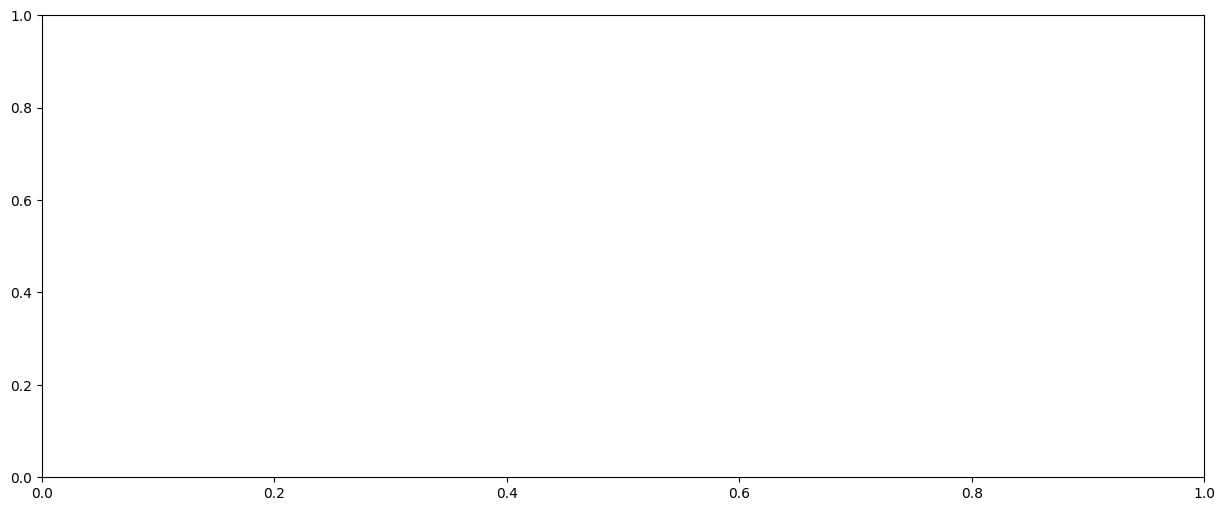

In [68]:
import matplotlib.pyplot as plt

# Cria o gráfico da DRE
fig, ax = plt.subplots(figsize=(15, 6))

# Plotando as barras empilhadas
tabela_pivot.drop(['LPA' , 'Lucro/Prejuízo Consolidado do Período'], axis=1).plot(kind='bar', stacked=True, ax=ax)

# Plotando a linha preta para 'Lucro/Prejuízo Consolidado do Período'
tabela_pivot[['Lucro/Prejuízo Consolidado do Período']].plot(ax=ax, color=['black'])

# Configurações do gráfico
ax.set_xlabel('Data')
ax.set_ylabel('R$')
ax.set_title(f'Demonstrações de Resultado {busca.upper()}')
ax.legend(loc='best')

plt.show()

KeyError: 'LPA'

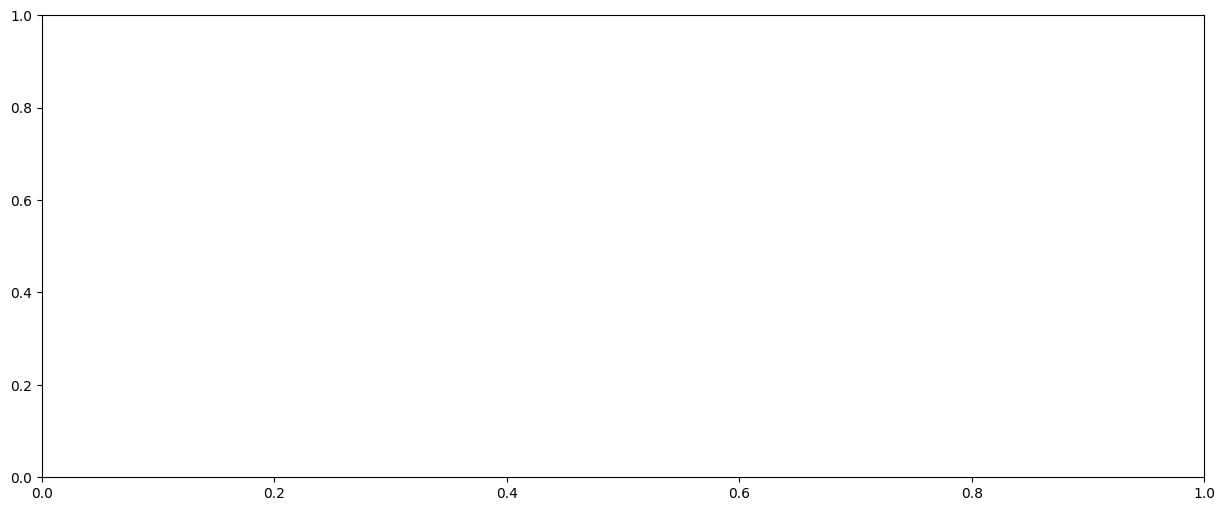

In [83]:
# Cria o gráfico
fig, ax = plt.subplots(figsize=(15, 6))

# Plota a linha para LPA
ax.plot(tabela_pivot.index, tabela_pivot['LPA'], color='black', label='LPA')

# Configurações do gráfico
ax.set_xlabel('Data')
ax.set_ylabel('LPA')
ax.set_title(f'Lucro por ação {busca.upper()}')
ax.legend(loc='best')

plt.show()
